In [1]:
# loading dependencies

import os  
import shutil
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import json
import random
import tensorflow as tf
import keras
from keras import layers
import multiprocessing
from tensorflow.keras.losses import CategoricalCrossentropy #trying different approach for bills
FILE_NAME = "./photos"

In [2]:
# do this first because can't do later
def configure_tensorflow_gpu():
    # turn on multiple cores.  Once started you cannot change it.
    num_cores = multiprocessing.cpu_count()
    tf.config.threading.set_intra_op_parallelism_threads(num_cores)
    # tf.config.threading.set_inter_op_parallelism_threads(2)
    # Make sure it is taking advantage of the gpu instead of cpu.  Faster
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu,True)
        except RuntimeError as e:
            print(f"no gpu from {e}")
    else:
        print("no gpu")
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
    return num_cores
    


In [3]:
configure_tensorflow_gpu()

10

In [44]:
def get_image_path(img_num):
    img_name = f"img{img_num}.png"
    img_path = os.path.join("./photos", img_name)
    return img_path

In [5]:
# might not need this, but I could always add a delete augmented.  definitely needed it for other trainings, ie YOLO
# but definitely stop accidentally running it
# save_image_copies("../final_project/google_collab_imgs", "./augmented_imgs_saved")


In [6]:
def get_json_path(img_num):
    img_num = img_num if img_num < 294 else img_num - 293 if img_num < 587 else img_num - 586
    json_name = f"img{img_num}.json"
    json_path = os.path.join("./photos",json_name)
    return json_path

In [7]:
# this function gets the x and y coordinates of where the money is.  I wanted to do this so that the holes
def get_x_y_coordinates_from_json(img_num):
    # get_json_path is hardcoed to 293 only 3 times
    json_path = get_json_path(img_num)
    with open(json_path, 'r') as f:
        data = json.load(f)
        points = data['shapes'][0]['points']
        avg_x = sum([point[0] for point in points]) / len(points)
        avg_y = sum([point[1] for point in points]) / len(points)
    return [avg_x, avg_y]


In [8]:
# also initally did this step so we could look at the augmentations and observe testing, however, this might be able to not save
# and go straight to putting the images into the tensor
def augment_img(img_num):
    img_path = get_image_path(img_num)
    img = Image.open(img_path)
    img = img.convert("RGB")
    img_array = np.array(img)
    xy = get_x_y_coordinates_from_json(img_num)
    img_array_augmented = random_img_augmentation(img_array, xy)
    return img_array_augmented
        
            

In [9]:
# augment_imgs("../final_project/google_collab_imgs")

In [10]:
def random_img_augmentation(img, xy):
    # Randomly choose a transformation from the ones below.  We also thought about flipping and rotating, but our actual bills 
    # were already flipped and rotated sufficiently with the images of the bills in all kinds of positions, we didn't think this
    # would provide enough difference.  Each value below was tweaked through trial and error to find sufficient blurrings/lightings/darkenings
    # to truly work the model but not too much to leave it completely unreadable.
    # The choice of adding holes had too many of the images with the holes completely away from the actual bills, so the choice was made
    # to include the x and y coordinates of the money to center the holes around where the money was located to make the holes more impactful
    choice = np.random.choice([ 'darken','lighten', 'blur', 'add_holes'])
    from PIL import Image, ImageFilter
    pil_img = Image.fromarray(img)
    if choice == 'darken':
        # found a good level here.  0.9 couldn't see any difference.  Wanted it to be something worthwhile
        factor = np.random.uniform(0.3, 0.1)
        pil_img = pil_img.point(lambda p: p * factor)
    elif choice == 'lighten':
        factor = np.random.uniform(2, 4) 
        pil_img = pil_img.point(lambda p: min(255, p * factor))
    elif choice == 'blur':
        blur_val = np.random.uniform(5, 13)
        pil_img = pil_img.filter(ImageFilter.GaussianBlur(radius=blur_val))
    elif choice == 'add_holes':
        avg_x, avg_y = xy
        draw = ImageDraw.Draw(pil_img)
        num_holes = np.random.randint(3, 10)
        for _ in range(num_holes):
            # 
            x1 = int(avg_x) + np.random.randint(-400, 400)
            y1 = int(avg_y) + np.random.randint(-400, 400)
            x2 = x1 + np.random.randint(50, 200)
            y2 = y1 + np.random.randint(50, 200)
            draw.rectangle([x1, y1, x2, y2], fill=(0, 0, 0))
    return np.array(pil_img)
    

In [11]:
# binary masks with the img_number coming in, the label_array of what we want masked crop, money, one, five, ten, etc
# bill_imagined wasn't working well here.
def create_binary_mask_from_json(img_num, label_array, img_shape):
    # so we don't have to create so many json files
    json_path = get_json_path(img_num)
    width, height = img_shape

    masks  = np.zeros((len(label_array), height, width), dtype = np.uint8)
    with open(json_path, 'r') as f:
        tags = json.load(f)

    for i, label in enumerate(label_array):
        temp_img = Image.new('L', (width,height),0)
        draw = ImageDraw.Draw(temp_img)

        for shape in tags['shapes']:
            if shape['label'] == label:
                points = shape['points']

                if len(points) == 2:
                    draw.rectangle([tuple(points[0]), tuple(points[1])], fill = 255)
                else:
                    draw.polygon([tuple(point) for point in points], fill = 255)
        temp_array = np.array(temp_img)
        masks[i] = np.maximum(masks[i], temp_array)
    return masks
    

In [12]:
def create_segmentation_dataset(label_array = ["money"],iters = 2, target_size = (256,256), mask=""):
    images = []
    masks = []
    imgs_processed = 0
    
    for img_num in range(1,294):
        json_path = get_json_path(img_num)
        img_path = get_image_path(img_num)
        try:
            image = Image.open(img_path).convert('RGB')
            img_size = image.size
            image_resized = np.array(image.resize(target_size)) / 255.0
            mask_arrays = create_binary_mask_from_json(img_num,label_array, img_size)
            
            # resize all masks and keep them separate for multi-channel approach
            processed_masks = []
            for mask_array in mask_arrays:
                mask_resized = np.array(Image.fromarray(mask_array).resize(target_size, Image.NEAREST))
                mask_resized = (mask_resized > 127).astype(np.float32)
                mask_resized = np.expand_dims(mask_resized, axis=-1)
                processed_masks.append(mask_resized)
            
            # Create multi-channel mask: concatenates along channel dimension
            combined_mask = np.concatenate(processed_masks, axis=-1)  # Shape: (256, 256, num_labels)
            for img_augmenting in range(2):
                augmented_img_array = augment_img(img_num)
                image_augmented = Image.fromarray(augmented_img_array)
                image_augmented_resized = np.array(image_augmented.resize(target_size)) / 255.0
                images.append(image_augmented_resized)
                masks.append(combined_mask)  # SAME JSON because SAME IMAGE JUST AUGMENTED
                imgs_processed += 1   
            imgs_processed += 1
            images.append(image_resized)
            masks.append(combined_mask)  # SAME JSON because SAME IMAGE JUST AUGMENTED
            if imgs_processed % 50 == 0:
                print(f"processed {imgs_processed}/879")
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue
    images = np.array(images)
    masks = np.array(masks)
    return images, masks     

In [13]:
# Hyperparameters 
IMG_SIZE = 256          # make images same size
BATCH_SIZE = 8          # 8 seems to be pretty standard
EPOCHS = 15             # can increase if needed
BASE_FILTERS = 96       
LEARNING_RATE = 5e-4    # made a high learning rate, for quicker learning
DROPOUT_RATE = 0.2      # dropout for some regularization
L2_REG = 1e-4           # weight decay, tried various
AUGMENT_DATA = False     # False, because we did it on our own, so we could see the image results and have greater control

In [14]:
# creating the images and masks for the values in the array
images, masks = create_segmentation_dataset(label_array = ["one","five","ten","twenty","fifty","hundred","money","crop"])

processed 150/879
processed 300/879
processed 450/879
processed 600/879
processed 750/879


In [15]:
def plot_image_and_masks(image, masks, label_array, img_num):
    num_masks = masks.shape[-1]
    total_plots = 1 + num_masks  # 1 for image + number of masks
    cols = 3
    rows = (total_plots + cols - 1) // cols  # Calculate required rows

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    axes = axes.flatten()  # Flatten to easily index

    # Plot the original image
    axes[0].imshow(image)
    axes[0].set_title(f"Original Image num{img_num}")
    axes[0].axis("off")

    # Plot each mask
    for i in range(num_masks):
        axes[i + 1].imshow(image)
        axes[i + 1].imshow(masks[:, :, i], cmap="gray", alpha=0.7)
        axes[i + 1].set_title(f"Mask: {label_array[i]}")
        axes[i + 1].axis("off")

    # Hide any unused subplots
    for j in range(total_plots, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

In [16]:
images[1].shape

(256, 256, 3)

In [17]:
masks[1].shape[-1]

8

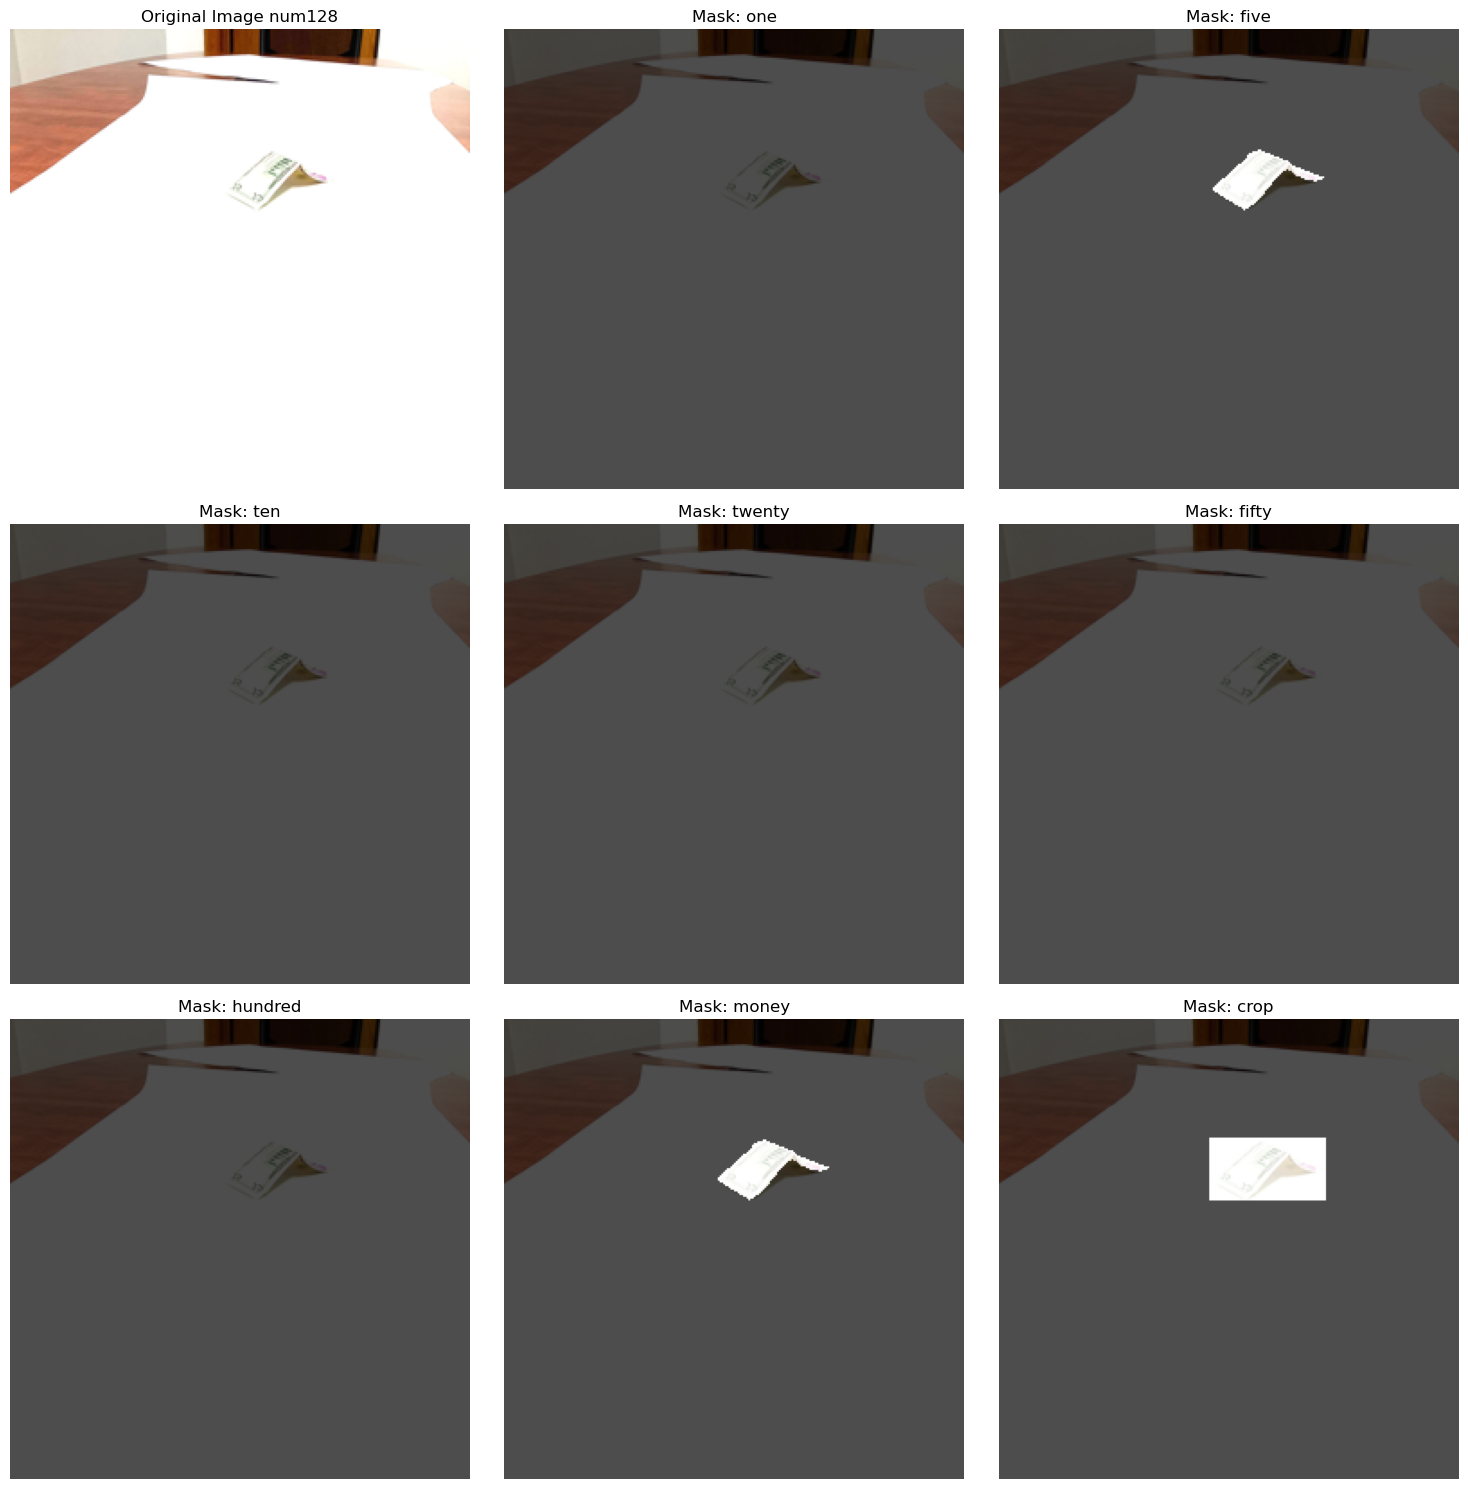

In [18]:
sample_index = random.randint(0, images.shape[0] - 1)
sample_image = images[sample_index]
sample_masks = masks[sample_index]
plot_image_and_masks(sample_image, sample_masks, ["one","five","ten","twenty","fifty","hundred","money","crop"],sample_index+1)

In [19]:
def double_conv_block(x, num_filters, dropout_rate=0.0):
    # First Conv2D layer with L2 regularization
    x = layers.Conv2D(filters=num_filters, kernel_size=(3, 3), padding="same", activation="relu",
                     kernel_regularizer=keras.regularizers.l2(L2_REG))(x)
    x = layers.BatchNormalization()(x)
    # Second Conv2D layer
    x = layers.Conv2D(filters=num_filters, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    return x


In [20]:
def encoder_block(x, num_filters):
    # x = # feature extraction (same H,W)
    x = double_conv_block(x, num_filters, dropout_rate=DROPOUT_RATE)
    # p = # downsample by 2
    p = layers.MaxPooling2D(pool_size=(2, 2), padding="valid")(x)
   
    return x, p

In [21]:
def decoder_block(x, skip, num_filters):
    # x = # upsample (H,W) x2
    x = layers.Conv2DTranspose(filters=num_filters, kernel_size=(3, 3), strides=2, padding="same")(x)
    # x = # fuse with encoder skip
    x = layers.Concatenate()([x, skip])
    # x = # refine features
    x = double_conv_block(x, num_filters, dropout_rate=DROPOUT_RATE/2)  # Less dropout in decoder
    
    return x

In [22]:
def make_unet(input_shape=(256, 256, 3), base_num_filters=32, num_classes=1, final_act=None):
    h, w, _ = input_shape
    # multiples of 16 needed
    assert h % 16 == 0 and w % 16 == 0

    inputs = keras.Input(shape=input_shape)

    # Encoder
    f1, p1 = encoder_block(inputs, base_num_filters)  # 256 -> 128
    f2, p2 = encoder_block(p1, base_num_filters * 2) # 128 -> 64
    f3, p3 = encoder_block(p2, base_num_filters * 4)# 64  -> 32
    f4, p4 = encoder_block(p3, base_num_filters * 8) # 32  -> 16

    # Bottleneck
    bn = double_conv_block(p4, base_num_filters * 16, dropout_rate=DROPOUT_RATE)

    # Decoder
    d4 = decoder_block(bn, f4, base_num_filters * 8)# 16 -> 32
    d3 = decoder_block(d4, f3, base_num_filters * 4)# 32 -> 64
    d2 = decoder_block(d3, f2, base_num_filters * 2)# 64 -> 128
    d1 = decoder_block(d2, f1, base_num_filters)# 128 -> 256

    # Head
    act = final_act if final_act is not None else ('sigmoid' if num_classes == 1 else 'softmax')
    outputs = layers.Conv2D(num_classes, 1, activation=act, padding='same')(d1)

    return keras.Model(inputs, outputs, name='U-Net')

In [23]:
# gets just the masks associated with the money.
money_masks = masks[:,:,:,-2]
# gets just crop mask. stopped using because money worked out well
crop_masks = masks[:,:,:,-1]
# denominations mask
denomination_masks = masks[:,:,:,:-2]
# never used the bill or bill_imagined masks, so never uploaded them from json

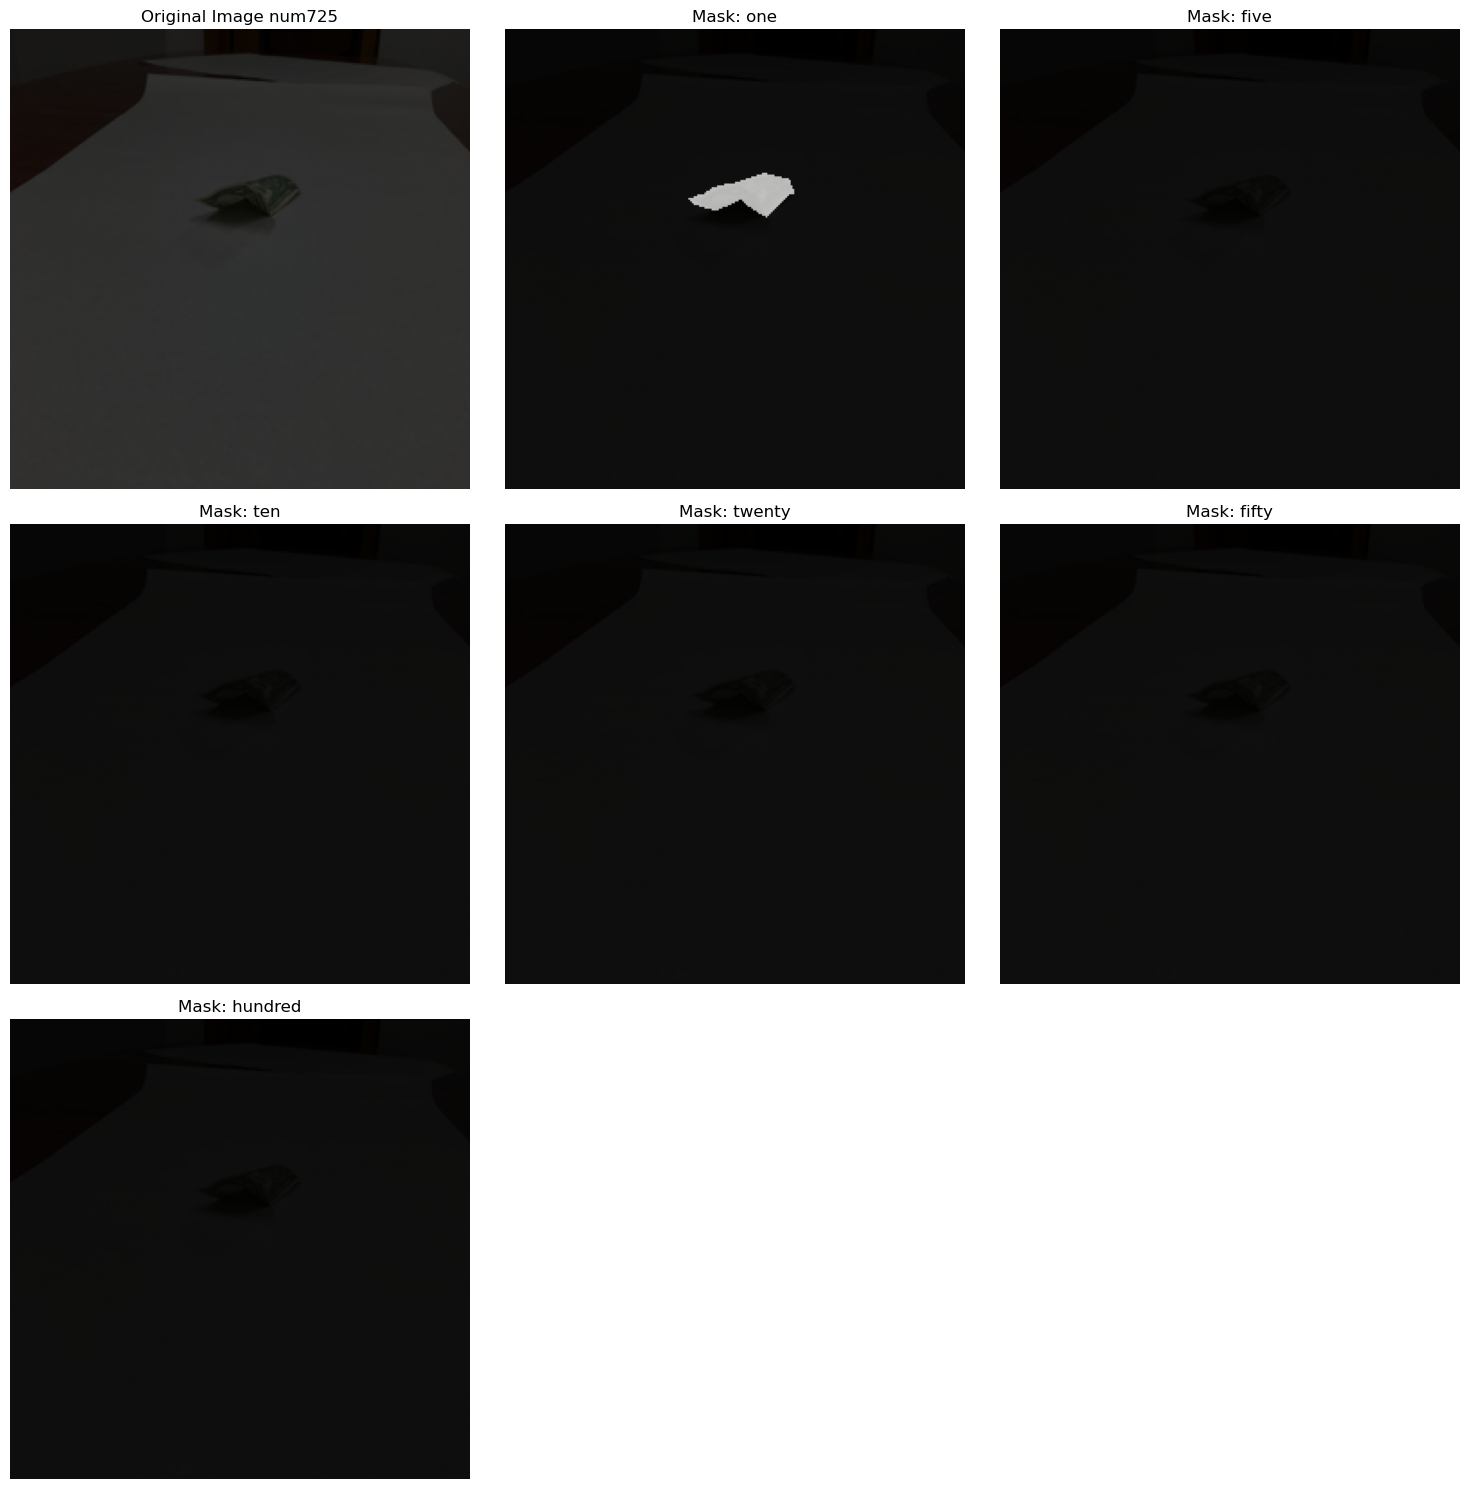

In [24]:
# checking a random image and all the masks
sample_index = random.randint(0, images.shape[0] - 1)
sample_image = images[sample_index]
sample_masks = denomination_masks[sample_index]
plot_image_and_masks(sample_image, sample_masks, ["one","five","ten","twenty","fifty","hundred",],sample_index+1)

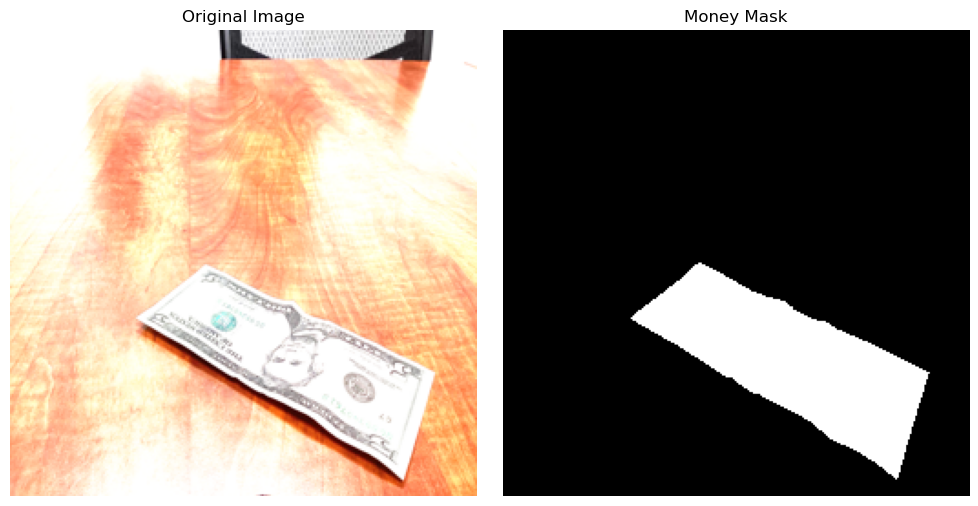

In [25]:
# checking just the money mask
sample_index = random.randint(0, images.shape[0] - 1)
sample_image = images[sample_index]
sample_money_mask = money_masks[sample_index]
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(sample_money_mask, cmap="gray")
plt.title("Money Mask")
plt.axis("off")

plt.tight_layout()
plt.show()

In [26]:
# loading the tensor with the images and their corresponding masks, here it is just the money
dataset_money = tf.data.Dataset.from_tensor_slices((images, money_masks))
dataset_money = dataset_money.shuffle(len(images), seed=21)

# tried different val_splits, started with .20 but 0.15 seemed to work better because we have such small training data
val_split = 0.15
val_size = int(len(images) * val_split)
train_size = len(images)- val_size

# get the training and the validating sets
train_dataset_money = dataset_money.skip(val_size).batch(BATCH_SIZE)
val_dataset_money = dataset_money.take(val_size).batch(BATCH_SIZE)
print(f"Train samples: {train_size}, Val samples: {val_size}")


Train samples: 748, Val samples: 131


In [27]:
# initiate the model, num_classes for future, and final_act because we initially were trying to create a multi-task UNET but that failed
model_money = make_unet(input_shape=(IMG_SIZE,IMG_SIZE,3), num_classes=1, final_act='sigmoid')

In [28]:
# added the ADAM optimizer, cross entropy and Intersection over Union.  Tried a bunch of different, this was best
# Even tried some hybrid loss function, but in the end didn't need it
model_money.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=CategoricalCrossentropy(), 
    metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=6)]
)


In [29]:
# training the model.  Started out with 10 epochs, but 15 was more the sweet spot.
money_hist = model_money.fit(
            train_dataset_money,
            validation_data=val_dataset_money,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,  
        )


Epoch 1/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 54s 498ms/step - accuracy: 0.7060 - loss: 135.1992 - mean_io_u: 0.4469 - val_accuracy: 0.8993 - val_loss: 152.7830 - val_mean_io_u: 0.4497
Epoch 2/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 45s 483ms/step - accuracy: 0.7313 - loss: 131.6303 - mean_io_u: 0.4471 - val_accuracy: 0.8974 - val_loss: 151.6299 - val_mean_io_u: 0.4487
Epoch 3/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 48s 508ms/step - accuracy: 0.7300 - loss: 125.9780 - mean_io_u: 0.4473 - val_accuracy: 0.6249 - val_loss: 129.6632 - val_mean_io_u: 0.5245
Epoch 4/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 47s 498ms/step - accuracy: 0.7551 - loss: 130.2798 - mean_io_u: 0.4455 - val_accuracy: 0.8940 - val_loss: 135.1858 - val_mean_io_u: 0.5249
Epoch 5/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 46s 486ms/step - accuracy: 0.7552 - loss: 128.7821 - mean_io_u: 0.4465 - val_accuracy: 0.7764 - val_loss: 146.3048 - val_mean_io_u: 0.4787
Epoch 6/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 46s 484ms/step - accuracy: 0.7666 - loss: 129.8126 - mean_io_u: 0.4542 - val_

In [30]:
def plot_history(hist, log_scale=False):
  plt.figure(figsize=(8,5))
  plt.plot(hist.history["loss"], color="blue", linestyle="-", label="train")
  plt.plot(hist.history["val_loss"], color="red", linestyle="--", label="val")

  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Training vs Validation Loss")
  plt.legend()
  plt.grid(True, which="both", ls=":")
  if log_scale:
      plt.yscale("log")
      plt.ylabel("Loss (log scale)")
  plt.show()

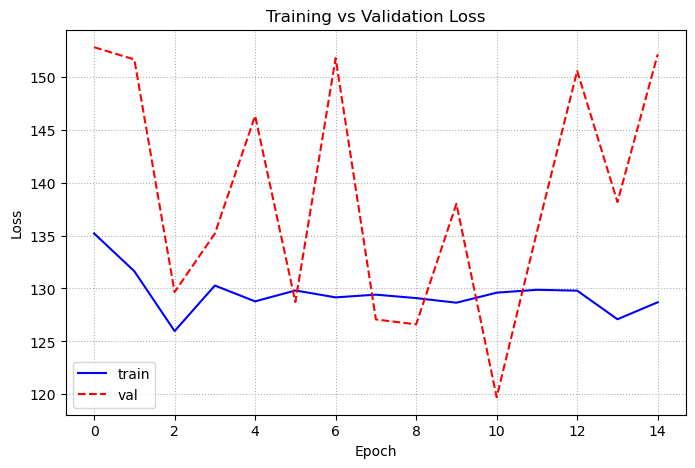

In [32]:
# ran multiple times, there was always a spike at some point
plot_history(money_hist)

In [31]:
model_money.save('money_segmentation_model.keras')

In [33]:
def plot_predictions_grid(images, masks, preds=None, num_samples=9):

    n = min(num_samples, len(images))
    cols = 3 if preds is not None else 2
    fig, axes = plt.subplots(nrows=n, ncols=cols, figsize=(5*cols, 3*n))

    for idx in range(num_samples):
        imag = images[idx]
        mask = masks[idx]
        pred  = preds[idx] if preds is not None else None

        # Original Image
        axes[idx, 0].set_title("Image")
        axes[idx, 0].imshow(imag)
        axes[idx, 0].axis("off")

        # Ground Truth Mask
        axes[idx, 1].set_title("Ground Truth Mask")
        axes[idx, 1].imshow(imag)
        axes[idx, 1].imshow(mask, cmap="grey", alpha=0.7)
        axes[idx, 1].axis("off")

        # Predicted Mask
        if preds is not None:
            axes[idx, 2].set_title("Predicted Mask")
            axes[idx, 2].imshow(imag)
            axes[idx, 2].imshow(pred, cmap="grey", alpha=0.7)
            axes[idx, 2].axis("off")

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


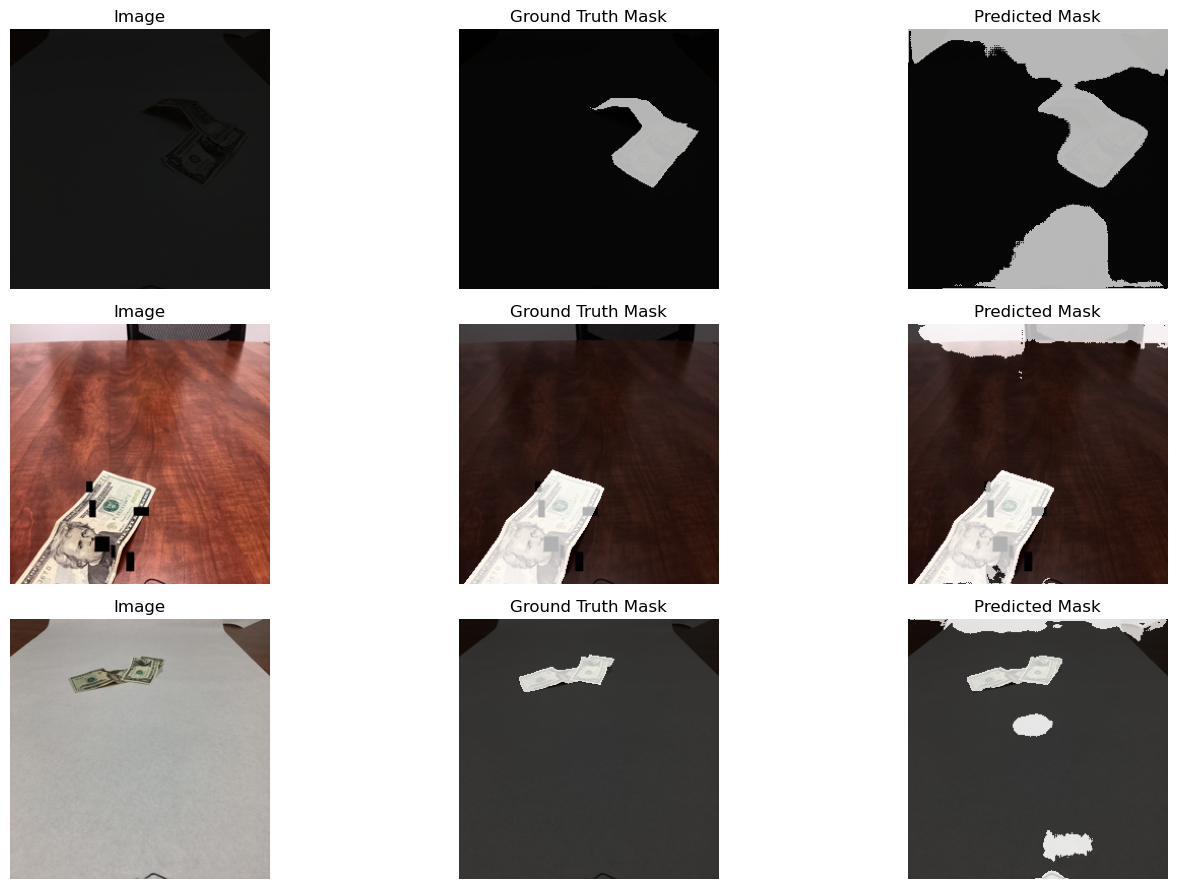

In [34]:
images_samp, masks_samp = next(iter(train_dataset_money))
preds = model_money.predict(images_samp)
preds = (preds > 0.3).astype("float32")  # threshold for binary mask
plot_predictions_grid(images_samp, masks_samp, preds, num_samples=3)

In [35]:
images.shape

(879, 256, 256, 3)

In [36]:
denomination_masks.shape

(879, 256, 256, 6)

In [37]:
money_predictions = model_money.predict(images, batch_size= BATCH_SIZE) 

110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step


In [38]:
money_predictions_binary = (money_predictions > 0.1).astype(np.float32)
processed_images = images * money_predictions_binary

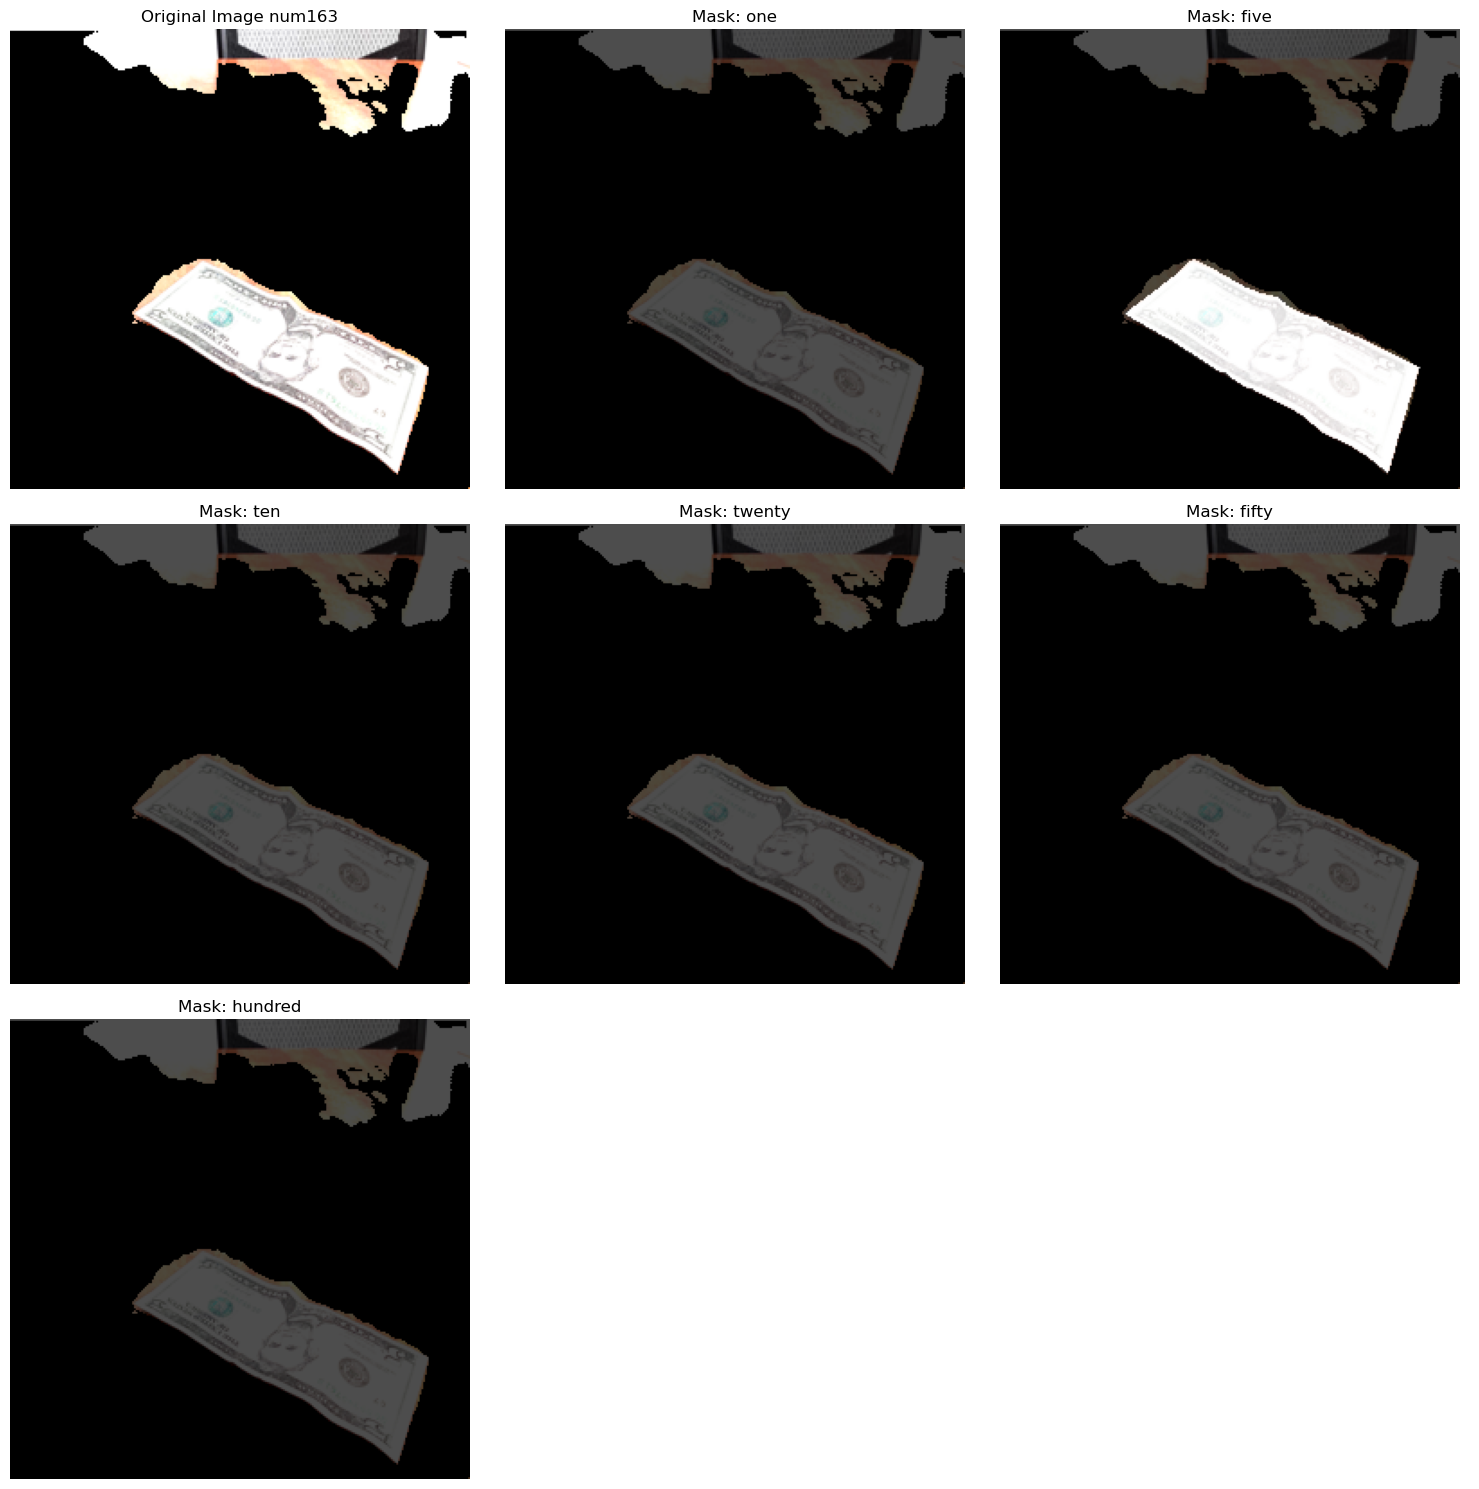

In [39]:
sample_index = random.randint(0, images.shape[0] - 1)
sample_image = processed_images[sample_index]
sample_masks = denomination_masks[sample_index]
plot_image_and_masks(sample_image, sample_masks, ["one","five","ten","twenty","fifty","hundred",],sample_index+1)

In [40]:
model_bills = make_unet(input_shape=(IMG_SIZE,IMG_SIZE,3), num_classes=6, final_act='sigmoid')

In [41]:
model_bills.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)


In [42]:
dataset_bills = tf.data.Dataset.from_tensor_slices((processed_images, denomination_masks))
dataset_bills = dataset_bills.shuffle(len(images), seed=21)

val_split = 0.15
val_size = int(len(images) * val_split)
train_size = len(images)- val_size

train_dataset_bills = dataset_bills.skip(val_size).batch(BATCH_SIZE)
val_dataset_bills = dataset_bills.take(val_size).batch(BATCH_SIZE)
print(f"Train samples: {train_size}, Val samples: {val_size}")


Train samples: 748, Val samples: 131


In [43]:
bill_hist = model_bills.fit(
            train_dataset_bills,
            validation_data=val_dataset_bills,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,  
        )


Epoch 1/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 517ms/step - accuracy: 0.0978 - loss: 0.4424 - val_accuracy: 0.7019 - val_loss: 1.8062
Epoch 2/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 46s 491ms/step - accuracy: 0.0670 - loss: 0.3937 - val_accuracy: 0.0604 - val_loss: 0.4203
Epoch 3/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 47s 496ms/step - accuracy: 0.0674 - loss: 0.3801 - val_accuracy: 0.0733 - val_loss: 0.4326
Epoch 4/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 47s 501ms/step - accuracy: 0.0503 - loss: 0.3780 - val_accuracy: 0.0215 - val_loss: 0.4165
Epoch 5/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 47s 498ms/step - accuracy: 0.0514 - loss: 0.3754 - val_accuracy: 0.0102 - val_loss: 0.4305
Epoch 6/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 47s 497ms/step - accuracy: 0.0517 - loss: 0.3782 - val_accuracy: 0.0543 - val_loss: 0.4045
Epoch 7/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 46s 492ms/step - accuracy: 0.0480 - loss: 0.3773 - val_accuracy: 0.0569 - val_loss: 0.4335
Epoch 8/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 47s 502ms/step - accuracy: 0.0463 - loss: 0.3815 - val_accu

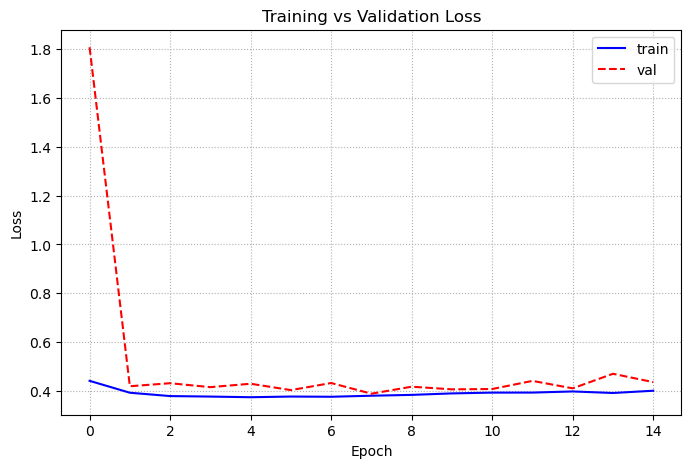

In [45]:
plot_history(bill_hist)


In [46]:
model_bills.save('bill_segmentation_model.keras')

In [47]:
images_samp, masks_samp = next(iter(train_dataset_bills))
preds = model_bills.predict(images_samp)
preds = (preds > 0.7).astype("float32")  # threshold for binary mask
# plot_predictions_grid(images_samp, masks_samp, preds, num_samples=3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


In [48]:
preds.shape

(8, 256, 256, 6)

In [49]:
images_samp.shape

TensorShape([8, 256, 256, 3])

In [50]:
masks_samp.shape

TensorShape([8, 256, 256, 6])

Predictions for one:


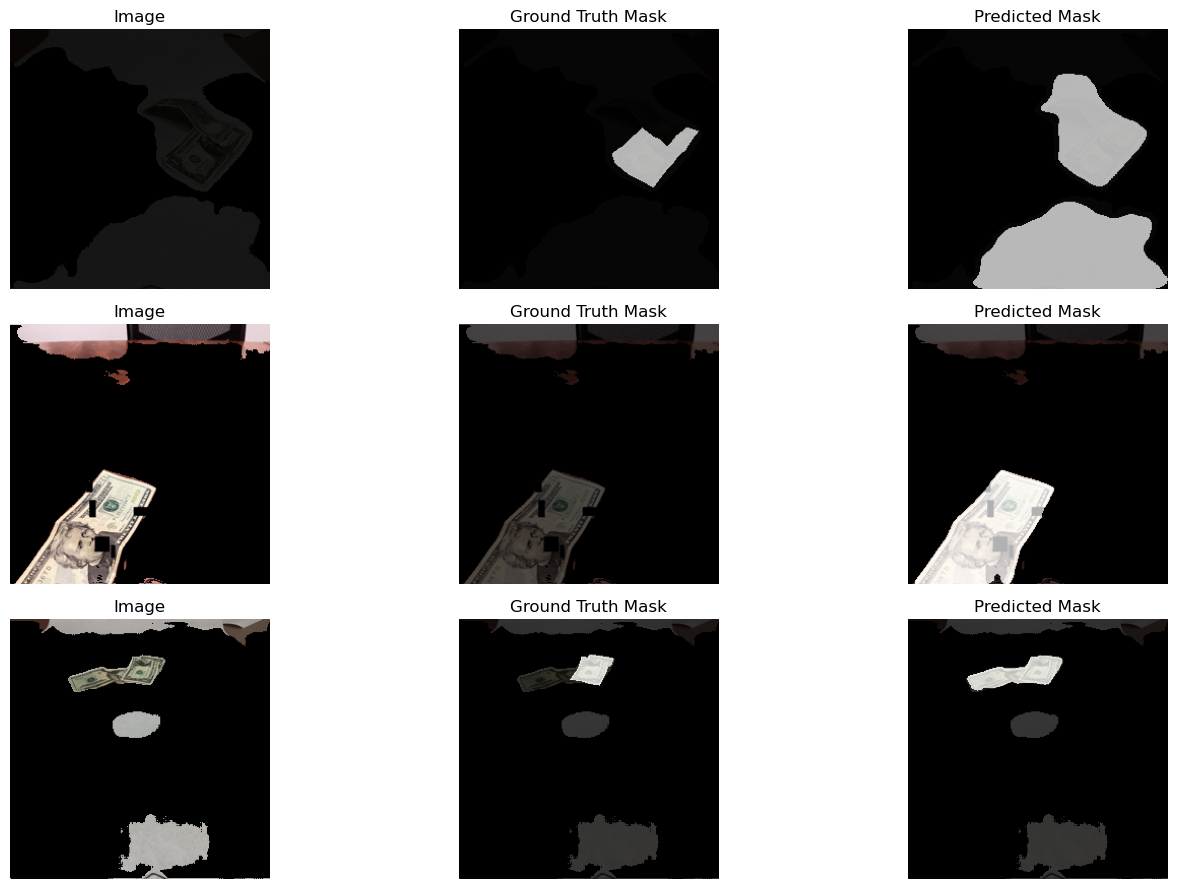

Predictions for five:


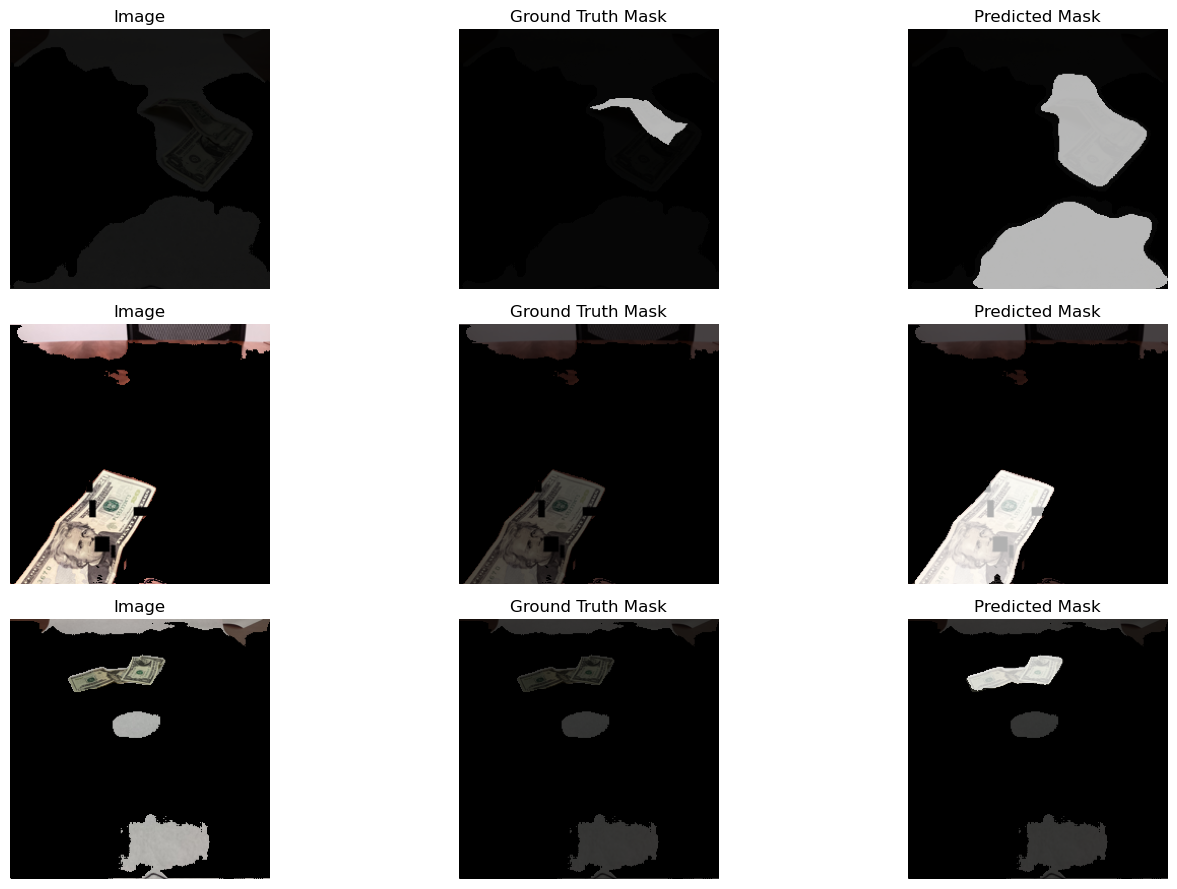

Predictions for ten:


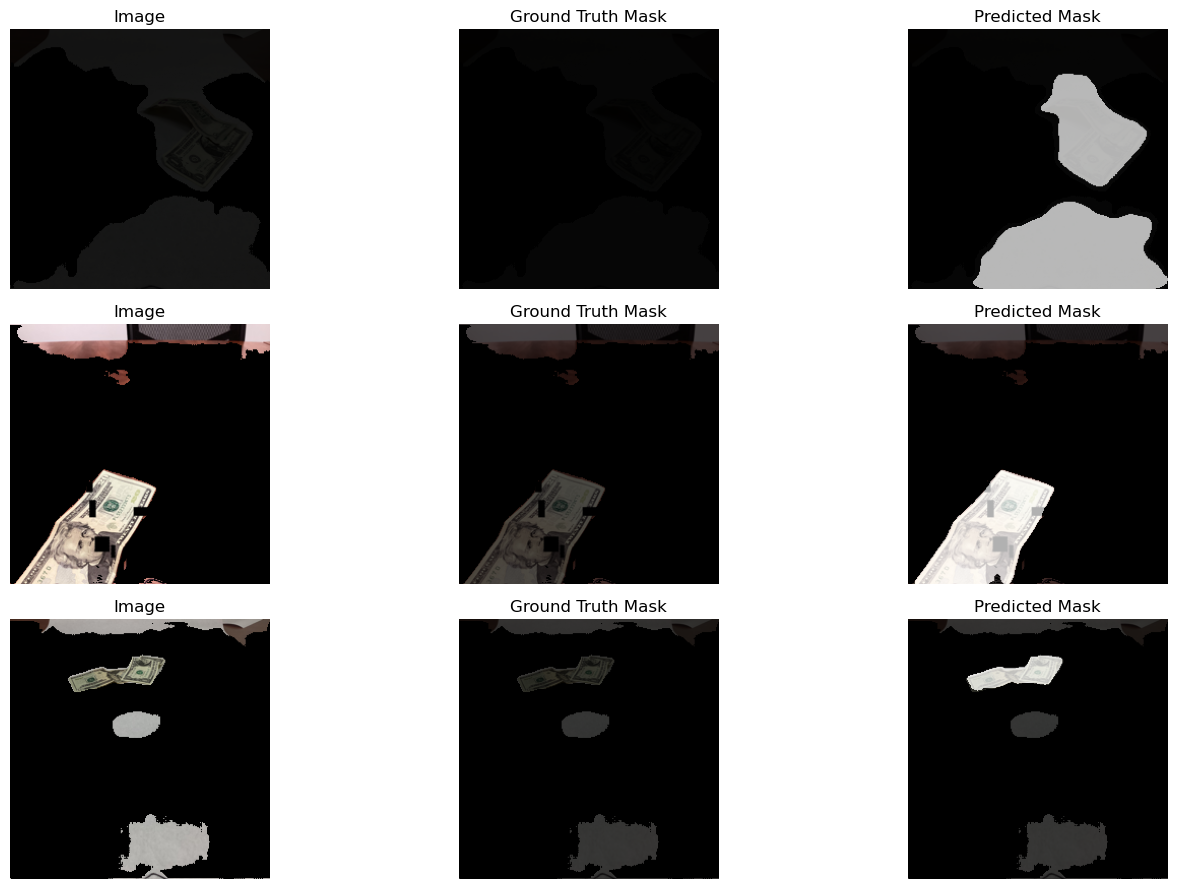

Predictions for twenty:


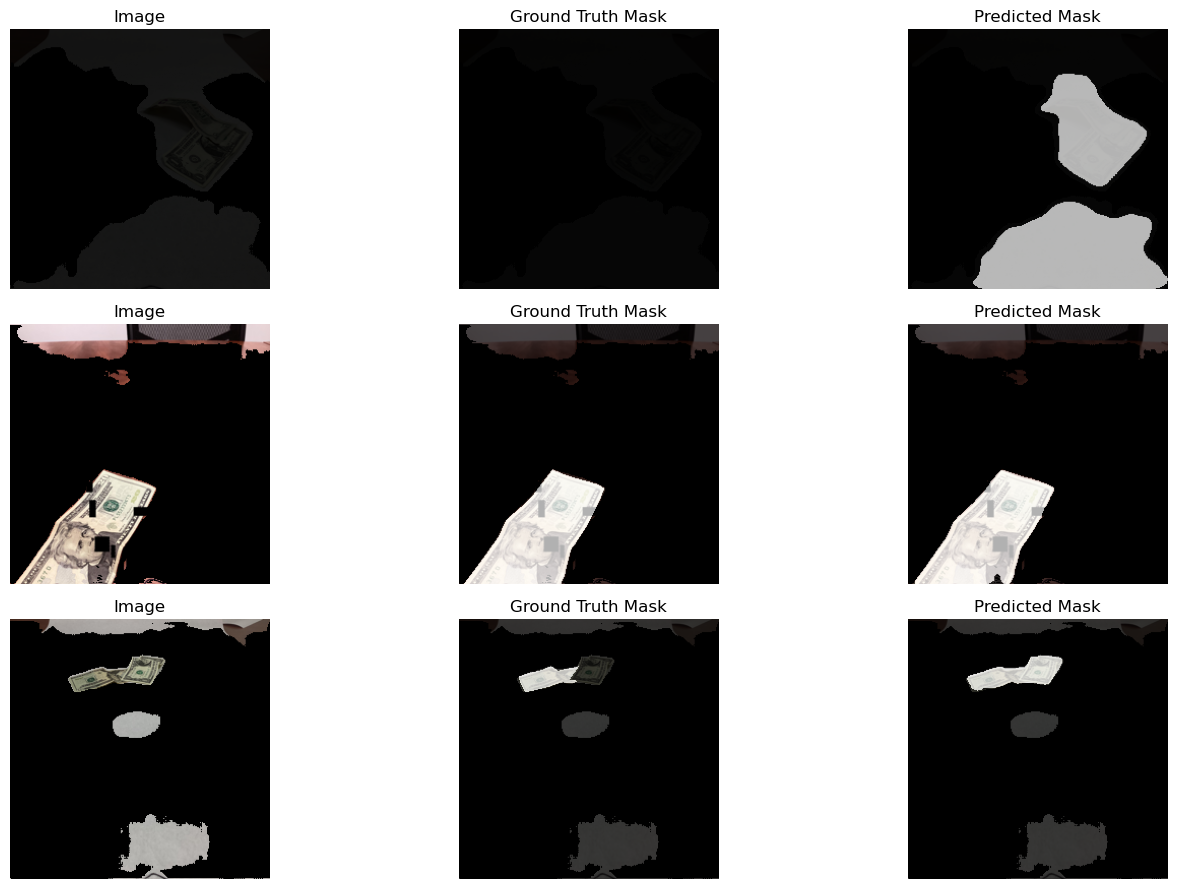

Predictions for fifty:


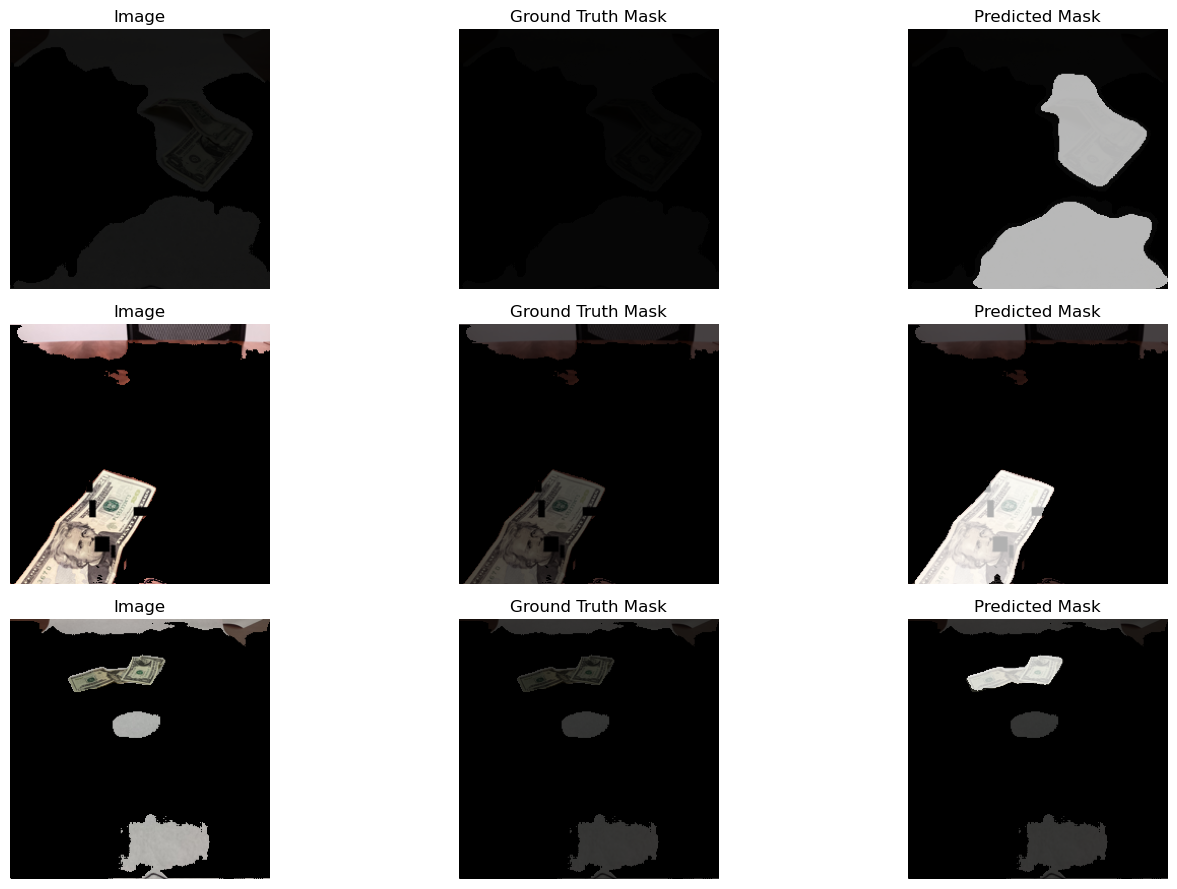

Predictions for hundred:


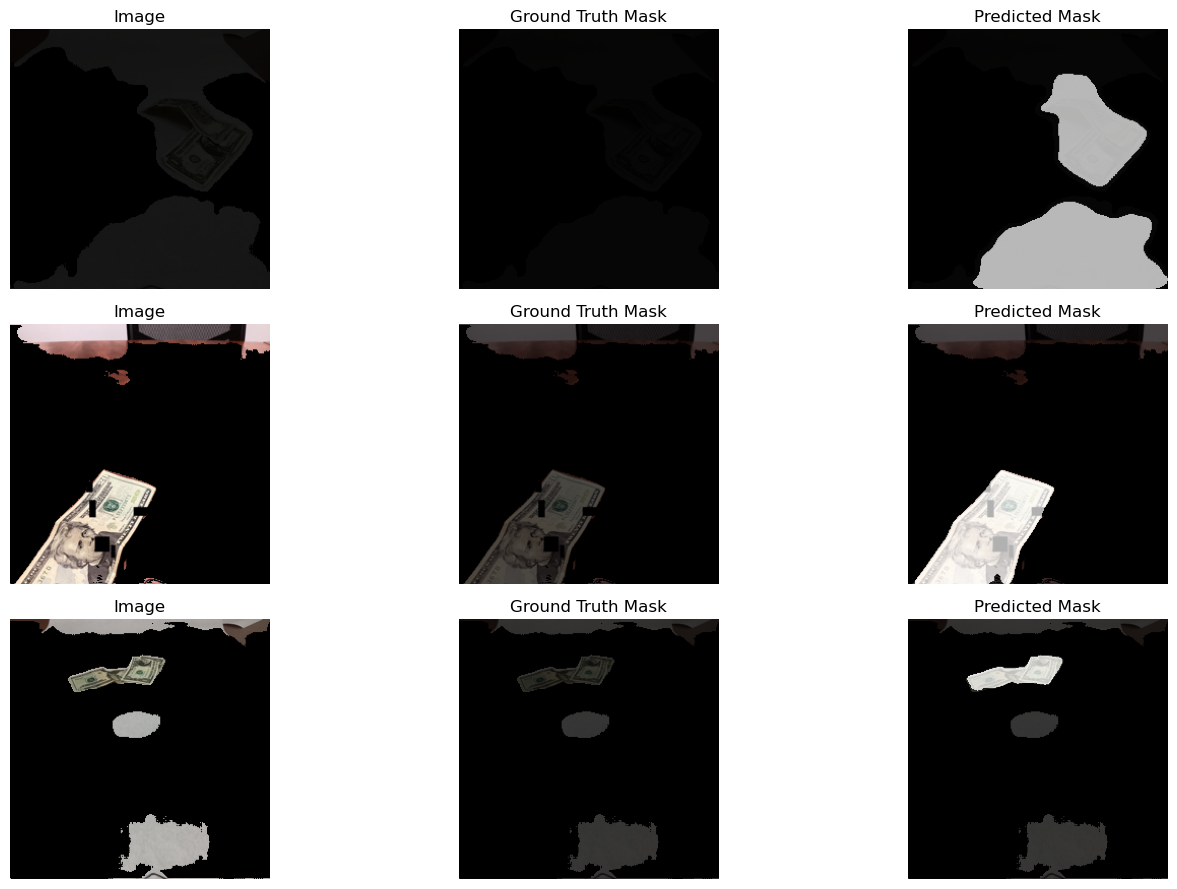

In [51]:
preds_list = [preds[:,:,:,i] for i in range(preds.shape[-1])]
masks_list = [masks_samp[:,:,:,i] for i in range(masks_samp.shape[-1])]
for i, label in enumerate(["one","five","ten","twenty","fifty","hundred"]):
    print(f"Predictions for {label}:")
    plot_predictions_grid(images_samp, masks_list[i], preds_list[i], num_samples=3)

In [52]:
for im, ma in train_dataset_bills.take():
    print("Unique label values in this batch:", np.unique(ma.numpy()))
    print("Mask shape:", ma.shape)      # should be (batch, 256, 256, 6)
    print("Max / min:", ma.numpy().max(), ma.numpy().min())

TypeError: DatasetV2.take() missing 1 required positional argument: 'count'